# 02_Integrate LT-HSC single cell ATAC seq with RNAseq

analysis of scATAC seq in LT-HSCs using Signac then tried to link to scRNAseq of LT-HSCs
- wasn't that successful

used this docker image

docker run \
--rm \
-d \
--name signac \
-p 8880:8888 \
-e JUPYTER_ENABLE_LAB=YES \
-v /Users/efast/Documents/:/home/jovyan/work \
signac_seurat:vs5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.2”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
counts <- Read10X_h5(filename = "/home/jovyan/work/X_likely_trash/Data/LT-HSCs/filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "/home/jovyan/work/X_likely_trash/Data/LT-HSCs/singlecell.csv",
  header = TRUE,
  row.names = 1
)

pbmc <- CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject(counts = counts, assay = "peaks", project = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."

In [3]:
fragment.path <- '/home/jovyan/work/X_likely_trash/Data/LT-HSCs/fragments.tsv.gz'

pbmc <- SetFragments(
  object = pbmc,
  file = fragment.path
)

In [4]:
pbmc <- NucleosomeSignal(object = pbmc)

Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

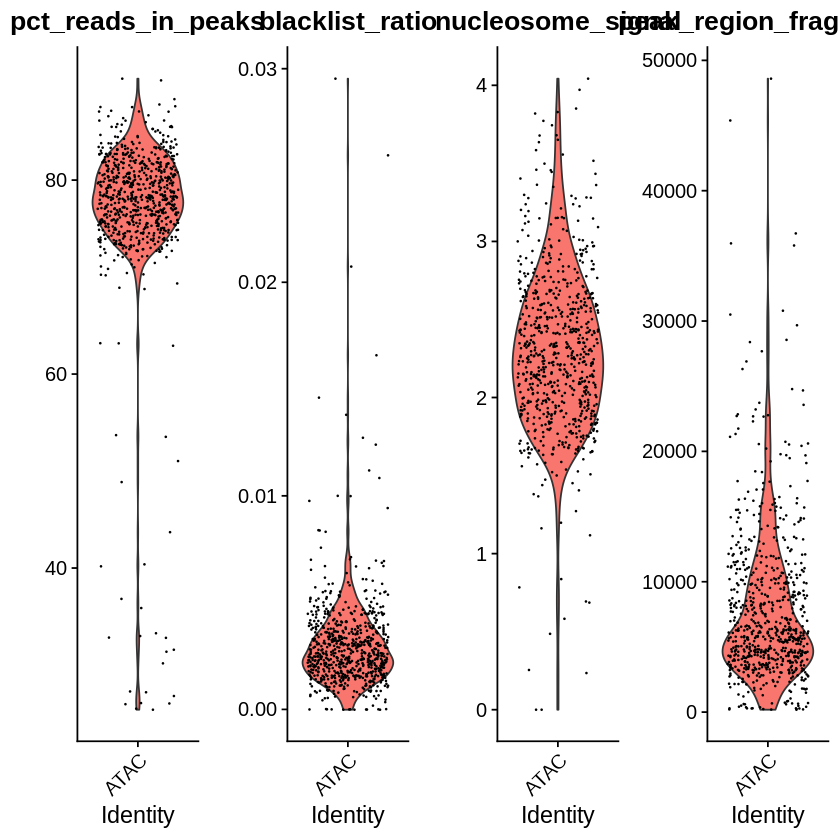

In [5]:
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 53 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

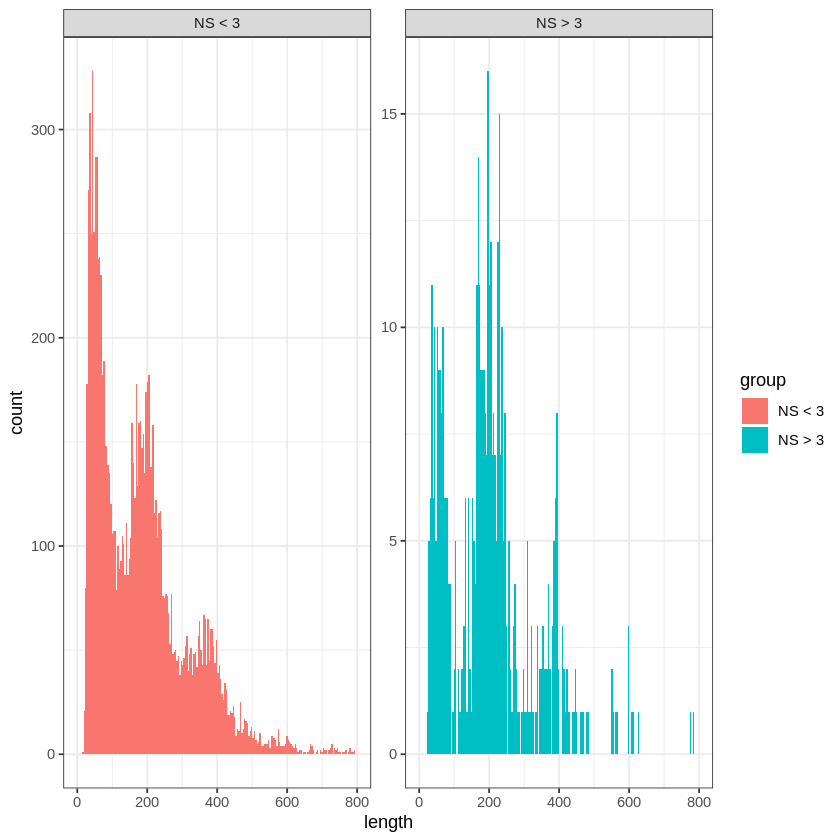

In [6]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 3, 'NS > 3', 'NS < 3')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [7]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
pbmc <- TSSEnrichment(object = pbmc, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


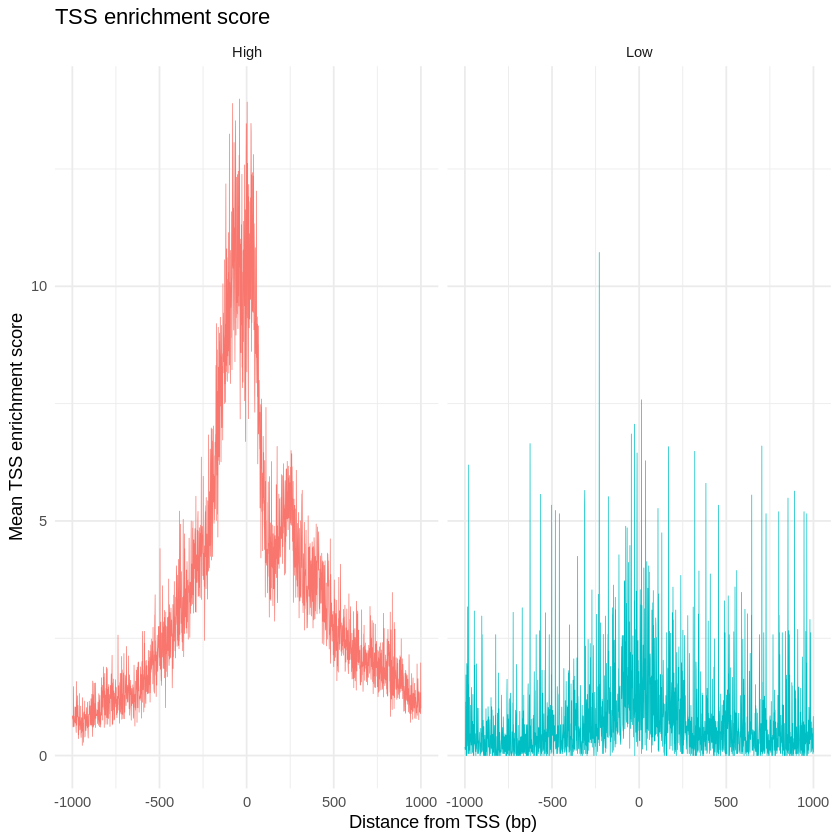

In [8]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()

In [9]:
pbmc <- subset(pbmc, subset = peak_region_fragments > 1000 & peak_region_fragments < 20000 & pct_reads_in_peaks > 15 & blacklist_ratio < 0.05 & nucleosome_signal < 10 & TSS.enrichment > 2)
pbmc

An object of class Seurat 
161427 features across 651 samples within 1 assay 
Active assay: peaks (161427 features)

In [10]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(
  object = pbmc,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"01:55:50 UMAP embedding parameters a = 0.9922 b = 1.112
01:55:50 Read 651 rows and found 30 numeric columns
01:55:50 Using Annoy for neighbor search, n_neighbors = 30
01:55:50 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
01:55:50 Writing NN index file to temp file /tmp/RtmpfFG5Tx/file1eda4e007b
01:55:50 Searching Annoy index using 1 thread, search_k = 3000
01:55:50 Annoy recall = 100%
01:55:51 Commencing smooth kNN distance calibration using 1 thread
01:55:53 Initializing from normalized Laplacian + noise
01:55:53 Commencing optimization f

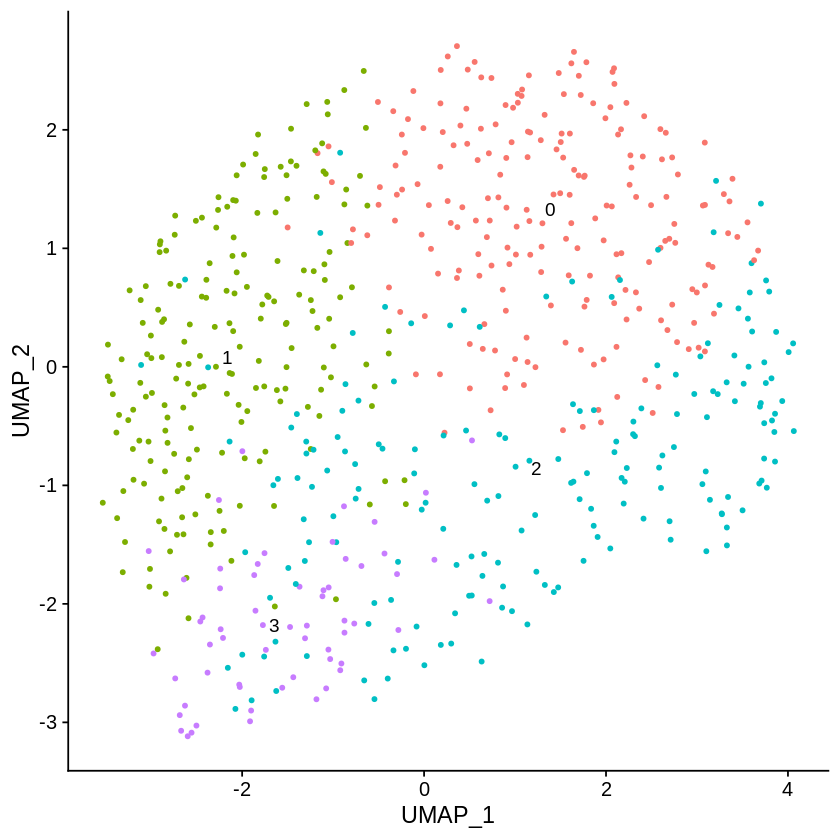

In [11]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 1:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 1:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE)
DimPlot(object = pbmc, label = TRUE) + NoLegend()

In [12]:
# add information about male cells as metainfomation

counts_df <- GetAssayData(object = pbmc, slot = "counts")
male_counts <- colSums(counts_df[161405:161427,])
pbmc$male <- male_counts
pbmc$male_binary <- pbmc$male
pbmc$male_binary[pbmc$male_binary > 0] <- 1

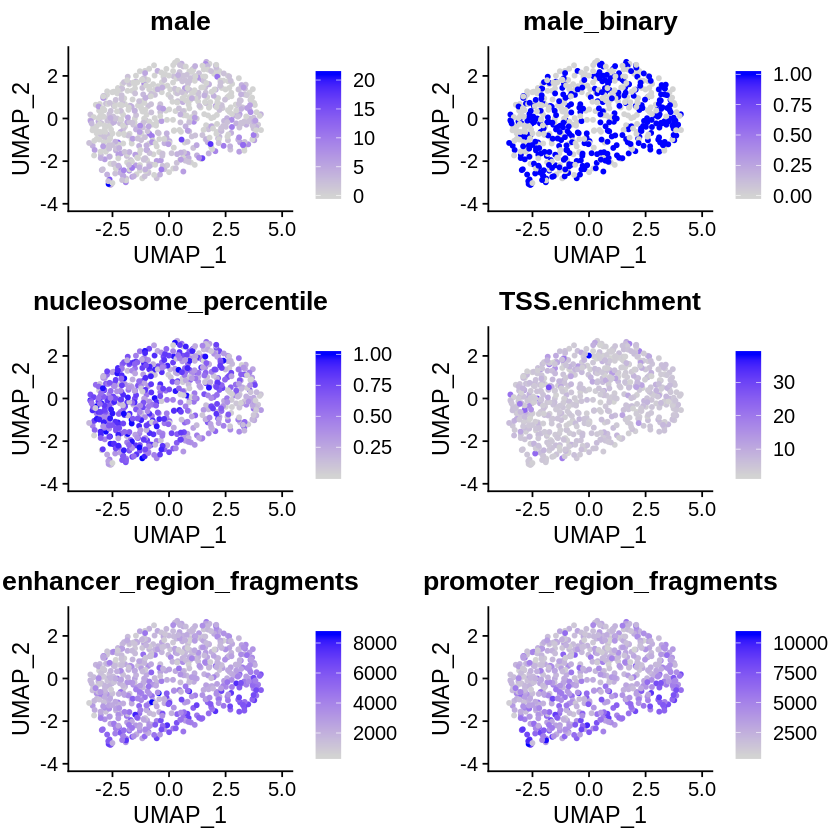

In [13]:
# plot some general stats about cells

FeaturePlot(pbmc, features = c("male", 
                               "male_binary", 
                               "nucleosome_percentile", 
                               'TSS.enrichment', 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), ncol = 2)

In [14]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(pbmc),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


In [15]:
DefaultAssay(pbmc) <- 'RNA'
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3


In [16]:
pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.854898e-07,0.2851769,0.856,0.819,0.0038095885,0,Ptpre
2.211878e-07,0.3053056,0.660,0.559,0.0045427561,0,Abi3
2.077616e-06,0.3065077,0.756,0.738,0.0426700775,0,Pmepa1
2.946004e-04,0.2712193,0.660,0.670,1.0000000000,0,Rin3
7.707388e-09,0.3412883,0.567,0.237,0.0001582943,3,Nfe2l3
6.473805e-05,0.2584523,0.550,0.315,1.0000000000,3,Crocc
1.232794e-04,0.2689237,0.700,0.442,1.0000000000,3,Ddx5
2.628268e-03,0.3519662,0.267,0.124,1.0000000000,3,Il34
2.781688e-03,0.2744213,0.467,0.296,1.0000000000,3,Cant1


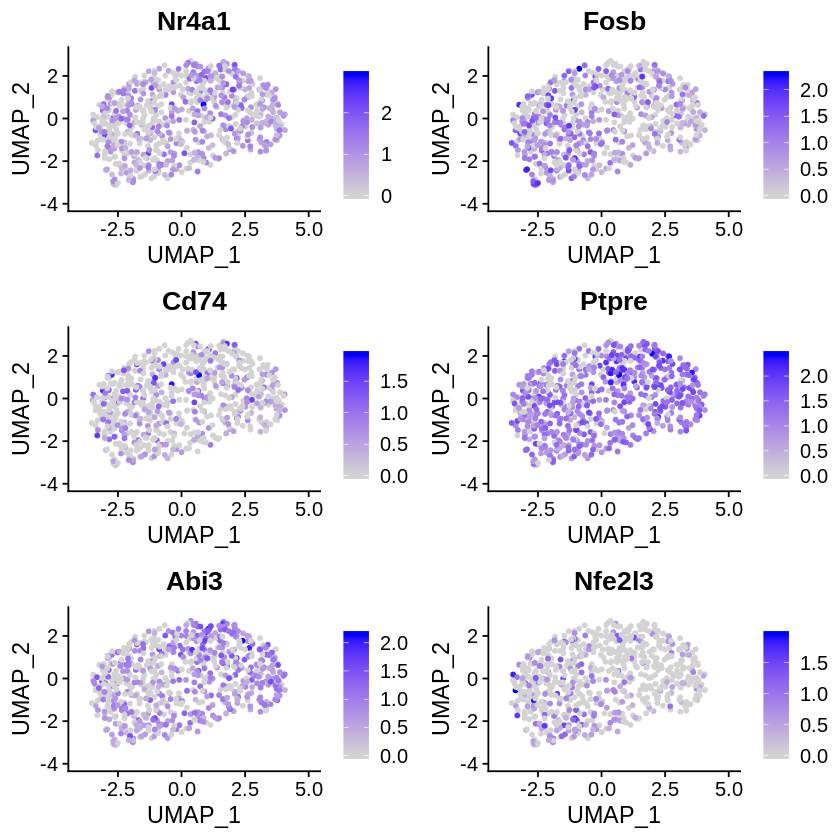

In [17]:
DefaultAssay(pbmc) <- 'RNA'
FeaturePlot(
  object = pbmc,
  features = c('Nr4a1', 'Fosb', 'Cd74','Ptpre', 'Abi3', 'Nfe2l3'),
  ncol = 2,
)


## extra preprocessing steps based on Seurat tutorial

https://satijalab.org/seurat/v3.1/atacseq_integration_vignette.html

In [18]:
DefaultAssay(pbmc) <- 'RNA'

pbmc <- FindVariableFeatures(pbmc)
pbmc <- NormalizeData(pbmc)
pbmc <- ScaleData(pbmc)

Centering and scaling data matrix


In [19]:
# read RNA data

pbmc.rna <- ReadH5AD(file = "./sc_objects/old_LT_preprocessed_old_scanpy.h5ad")

Pulling expression matrices and metadata
Data is scaled
Merging feature-level metadata dataframes
Creating assay object
Storing X as scale.data and raw as data
Setting highly variable features
Pulling dimensional reduction information
Pulling cell embeddings
Pulling feature loadings
Warning message:
"No columnames present in cell embeddings, setting to 'PC_1:50'"Warning message:
"No columnames present in cell embeddings, setting to 'UMAP_1:2'"Assembling Seurat object
Finding nearest neighbor graph
Warning message:
"Adding a Graph without an assay associated with it"No additional layers found


In [20]:
pbmc.rna$tech <- "rna"

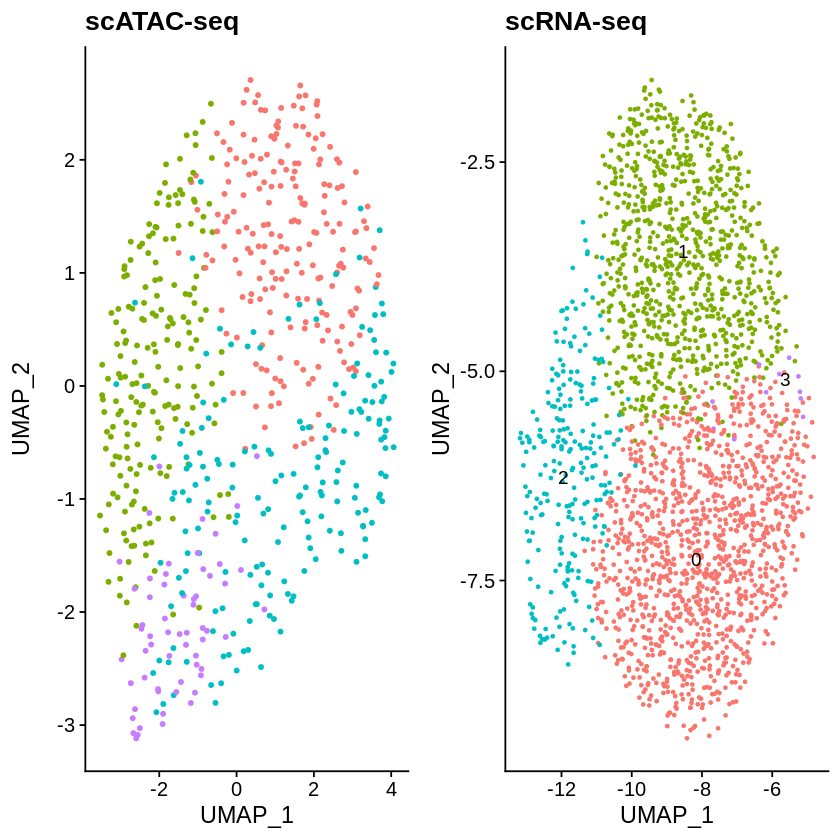

In [21]:
p1 <- DimPlot(pbmc, reduction = "umap") + NoLegend() + ggtitle("scATAC-seq")
p2 <- DimPlot(pbmc.rna, group.by = "leiden", label = TRUE, repel = TRUE) + NoLegend() + ggtitle("scRNA-seq")
CombinePlots(plots = list(p1, p2))

In [22]:
transfer.anchors <- FindTransferAnchors(
  reference = pbmc.rna,
  query = pbmc,
  reference.assay = 'RNA',
  query.assay = 'RNA',
  reduction = 'cca',
  features = peaks.use,
  k.filter = NA
)


Warning message:
"Adding a Graph without an assay associated with it"Warning message:
"Adding a Graph without an assay associated with it"

ERROR: Error in features %||% VariableFeatures(object = reference): object 'peaks.use' not found


In [23]:
transfer.anchors <- FindTransferAnchors(reference = pbmc.rna, query = pbmc, 
                                        features = VariableFeatures(object = pbmc.rna), 
                                        reference.assay = "RNA", query.assay = "RNA", reduction = "cca")

Warning message:
"Adding a Graph without an assay associated with it"Warning message:
"Adding a Graph without an assay associated with it"Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 3223 anchors
Filtering anchors
	Retained 1806 anchors
Extracting within-dataset neighbors


In [24]:
str(pbmc.rna)

Formal class 'Seurat' [package "Seurat"] with 12 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       : num[0 , 0 ] 
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:4597185] 2 3 17 20 31 33 35 41 44 56 ...
  .. .. .. .. .. ..@ p       : int [1:2383] 0 2442 4397 5779 7505 9140 10689 12397 14518 16319 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 14397 2382
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:14397] "Sox17" "Mrpl15" "Lypla1" "Tcea1" ...
  .. .. .. .. .. .. ..$ : chr [1:2382] "GGCGACTAGCCTTGAT-1" "CGTTCTGCACGGTGTC-1" "AGTCTTTGTTATCCGA-1" "GCGCCAACAGTATAAG-1" ...
  .. .. .. .. .. ..@ x       : num [1:4597185] 0.907 1.692 1.375 0.907 3.845 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ scale.data   : num [1:1275, 1:2382] -0.26 -0.537 -0.338 3.048 -0.066 ...
  .. .. .. .. ..- attr(*, "dimnames")=L

In [25]:
# had to make leiden categories from integer into characters

pbmc.rna$leiden <- as.character(pbmc.rna$leiden)

celltype.predictions <- TransferData(anchorset = transfer.anchors, refdata = pbmc.rna$leiden, 
    weight.reduction = pbmc[["lsi"]])
pbmc <- AddMetaData(pbmc, metadata = celltype.predictions)

Finding integration vectors
Finding integration vector weights
Predicting cell labels


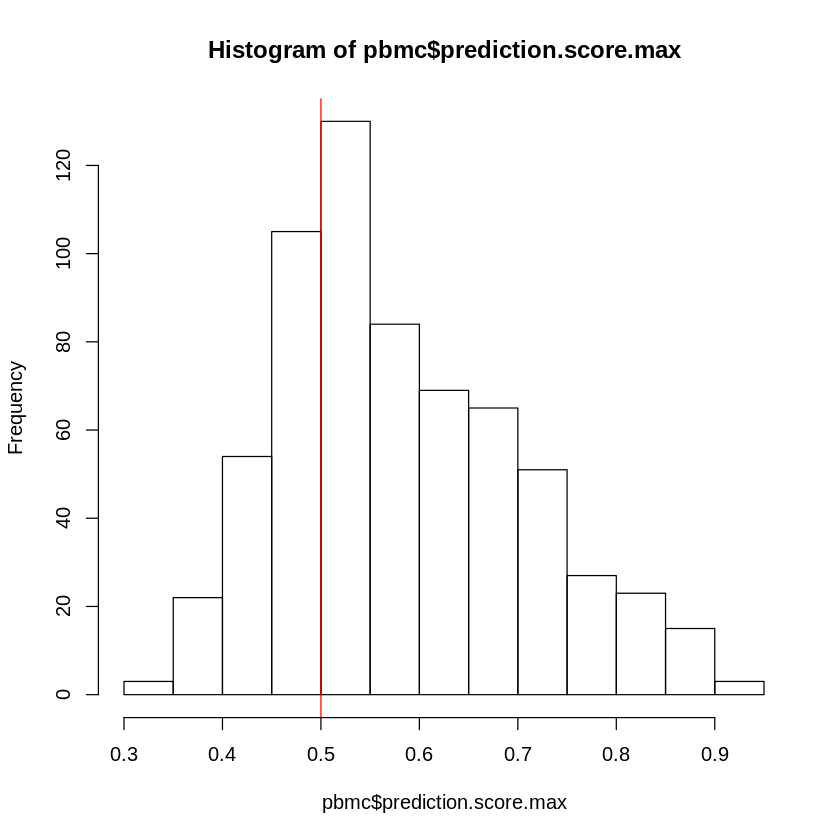

In [26]:
hist(pbmc$prediction.score.max)
abline(v = 0.5, col = "red")

In [27]:
# over 45% is the best cutoff
table(pbmc$prediction.score.max > 0.45)


FALSE  TRUE 
   79   572 

Warning message:
"Removed 572 rows containing missing values (geom_text_repel)."

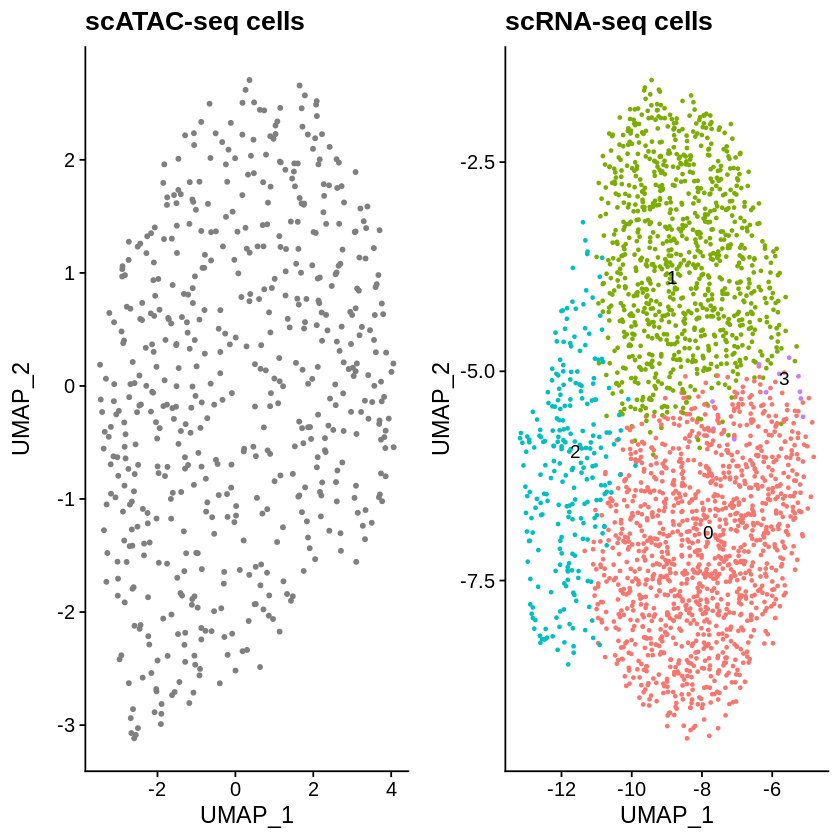

In [28]:
pbmc.filtered <- subset(pbmc, subset = prediction.score.max > 0.45)
pbmc.filtered$predicted.id <- factor(pbmc.filtered$predicted.id, levels = levels(pbmc.rna))  # to make the colors match
p1 <- DimPlot(pbmc.filtered, group.by = "predicted.id", label = TRUE, repel = TRUE) + ggtitle("scATAC-seq cells") + 
    NoLegend() + scale_colour_hue(drop = FALSE)
p2 <- DimPlot(pbmc.rna, group.by = "leiden", label = TRUE, repel = TRUE) + ggtitle("scRNA-seq cells") + 
    NoLegend()
CombinePlots(plots = list(p1, p2))

In [29]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(pbmc.rna)
refdata <- GetAssayData(pbmc.rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = pbmc[["lsi"]])

# this line adds the imputed data matrix to the pbmc.atac object
pbmc[["RNA_i"]] <- imputation
coembed <- merge(x = pbmc.rna, y = pbmc)

# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)
coembed$leiden <- ifelse(!is.na(coembed$leiden), coembed$leiden, coembed$predicted.id)

Finding integration vectors
Finding integration vector weights
Transfering 347 features onto reference data
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_i_ to rnai_"Centering data matrix
02:00:48 UMAP embedding parameters a = 0.9922 b = 1.112
02:00:48 Read 3033 rows and found 30 numeric columns
02:00:48 Using Annoy for neighbor search, n_neighbors = 30
02:00:48 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
02:00:48 Writing NN index file to temp file /tmp/RtmpfFG5Tx/file1ed68b36a19
02:00:48 Searching Annoy index using 1 thread, search_k = 3000
02:00:49 Annoy recall = 100%
02:00:50 Commencing smooth kNN distance calibration using 1 thread
02:00:51 Found 2 connected components, falling back to 'spca' initialization with init_sdev = 1
02:00:51 Initializ

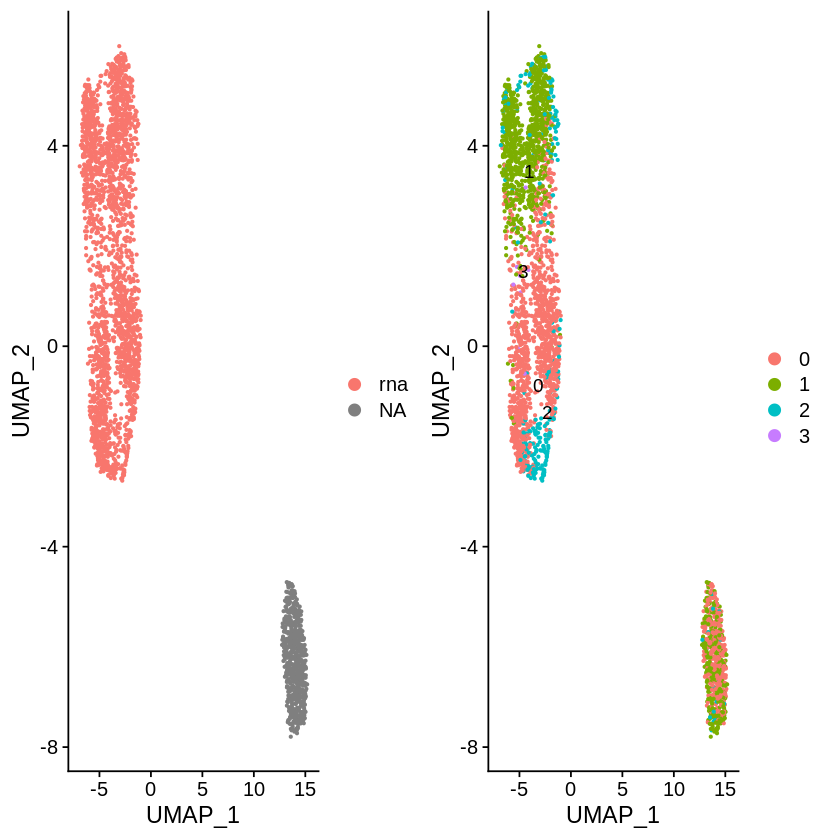

In [30]:
p1 <- DimPlot(coembed, group.by = "tech")
p2 <- DimPlot(coembed, group.by = "leiden", label = TRUE, repel = TRUE)
CombinePlots(list(p1, p2))

Warning message:
"Removed 3 rows containing missing values (geom_text_repel)."

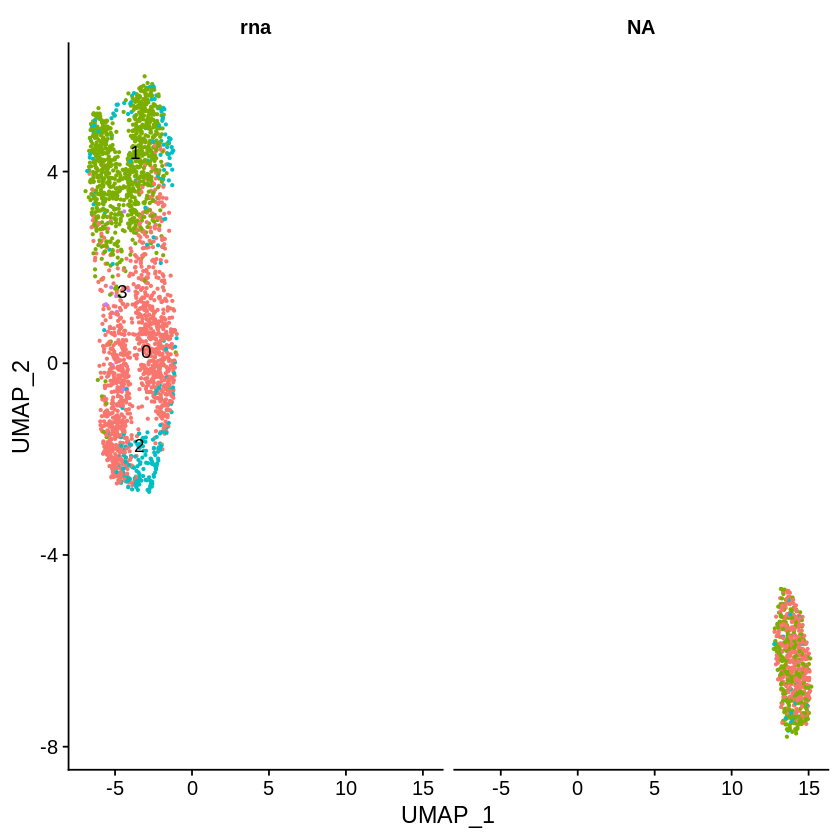

In [31]:
DimPlot(coembed, split.by = "tech", group.by = "leiden", label = TRUE, repel = TRUE) + NoLegend()

#### seems like that wasn't super successful!